In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import setuptools.dist
import torchvision.transforms as transforms
import sklearn 
import tensorflow
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from torchvision.datasets import CIFAR10

class ArtBench10(CIFAR10):

    base_folder = "artbench-10-batches-py"
    url = "https://artbench.eecs.berkeley.edu/files/artbench-10-python.tar.gz"
    filename = "artbench-10-python.tar.gz"
    tgz_md5 = "9df1e998ee026aae36ec60ca7b44960e"
    train_list = [
        ["data_batch_1", "c2e02a78dcea81fe6fead5f1540e542f"],
        ["data_batch_2", "1102a4dcf41d4dd63e20c10691193448"],
        ["data_batch_3", "177fc43579af15ecc80eb506953ec26f"],
        ["data_batch_4", "566b2a02ccfbafa026fbb2bcec856ff6"],
        ["data_batch_5", "faa6a572469542010a1c8a2a9a7bf436"],
    ]

    test_list = [
        ["test_batch", "fa44530c8b8158467e00899609c19e52"],
    ]
    meta = {
        "filename": "meta",
        "key": "styles",
        "md5": "5bdcafa7398aa6b75d569baaec5cd4aa",
    }

In [2]:
#Big ole setup from the CNN notebook, wasn't sure what to keep and what not to, so I just kept it all

import random
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, InputLayer
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)

def one_hot_encoding(input):
  output = np.zeros((input.size, input.max()+1))
  output[np.arange(input.size), input] = 1

  return output


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  !wget -q --show-progress -O cifar_data https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));

  data   = data_dict['data']
  labels = data_dict['labels']

  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt

  my_img   = data[img_idx, :].reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print(f'label: {my_label}')

  fig, ax = plt.subplots(1,1)
  img = ax.imshow(my_img.astype('uint8'), extent=[-1,1,-1,1])

  x_label_list = [0, 8, 16, 24, 32]
  y_label_list = [0, 8, 16, 24, 32]

  ax.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax.set_yticks([-1, -0.5, 0, 0.5, 1])

  ax.set_xticklabels(x_label_list)
  ax.set_yticklabels(y_label_list)

  fig.show(img)

def logits_to_one_hot_encoding(input):
    """
    Converts softmax output (logits) to a one-hot encoded format.

    This function takes an array of softmax output probabilities
    (usually from a neural network's output layer) and converts
    each row to a one-hot encoded vector. The highest probability
    in each row is marked as 1, with all other values set to 0.

    Parameters:
    input (numpy.ndarray): A 2D array where each row contains softmax probabilities for each class.
                            The shape of the array is (n_samples, n_classes).

    Returns:
    numpy.ndarray: A 2D array of the same shape as the input, where each row is the one-hot encoded representation
                   of the class with the highest probability in the original row.
    """

    output = np.zeros_like(input, dtype=int)
    output[np.arange(len(input)), np.argmax(input, axis=1)] = 1
    return output


class CNNClassifier:
    """
    A Convolutional Neural Network (CNN) classifier using Keras, customized for binary classification tasks.

    This class wraps a Keras Sequential model with a specific architecture suitable for image classification tasks.
    It includes a custom `predict` method that outputs one-hot encoded predictions, and other standard Keras model
    methods are accessible as well. This was done to override the need for the SciKeras wrappers that is frequently
    incompatible with Google Colab versions of Keras & Tensorflow. Feel free to modify as needed.

    Attributes:
        num_epochs (int): The number of training epochs.
        layers (int): The number of convolutional layers in the model.
        dropout (float): The dropout rate used in dropout layers for regularization.
        model (keras.models.Sequential): The underlying Keras Sequential model.

    Methods:
        build_model(): Constructs the CNN model with the specified architecture and compiles it.

        fit(*args, **kwargs): Trains the model. Accepts arguments compatible with the Keras `fit` method.

        predict(*args, **kwargs): Predicts labels for the input data. Converts the softmax output of the model
                                  to one-hot encoded format using `logits_to_one_hot_encoding`. Necessary to match
                                  accuracy_score function expected arguments.

        predict_proba(*args, **kwargs): Predicts labels for the input data and returns the raw output of the softmax.
                                        Used when wanting to inspect the raw probabilistic scoring of the model.

    Usage:
        cnn_classifier = CNNClassifier(num_epochs=30, layers=4, dropout=0.5)
        cnn_classifier.fit(X_train, y_train)
        predictions = cnn_classifier.predict(X_test)

    Note:
        The `__getattr__` method is overridden to delegate attribute access to the underlying Keras model,
        except for the `predict` method which is customized.
    """
    def __init__(self, num_epochs=30, layers=4, dropout=0.5):
        self.num_epochs = num_epochs
        self.layers = layers
        self.dropout = dropout
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Reshape((32, 32, 3)))

        for i in range(self.layers):
          model.add(Conv2D(32, (3, 3), padding='same'))
          model.add(Activation('relu'))

        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(self.dropout))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(self.dropout))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(self.dropout))
        model.add(Dense(10))
        model.add(Activation('softmax'))
        opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        return model

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, epochs=self.num_epochs, batch_size=10, verbose=2, **kwargs)

    #NOTE: WRITTEN TO RETURN ONE HOT ENCODINGS FOR ACCURACY
    def predict(self, *args, **kwargs):
        predictions = self.model.predict(*args, **kwargs)
        return logits_to_one_hot_encoding(predictions)

    def predict_proba(self, *args, **kwargs):
        predictions = self.model.predict(*args, **kwargs)
        return predictions

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

    def __getattr__(self, name):
        if name != 'predict' and name != 'predict_proba':
            return getattr(self.model, name)
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")


def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 7)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

<>:219: SyntaxWarning: invalid escape sequence '\d'
<>:220: SyntaxWarning: invalid escape sequence '\d'
<>:221: SyntaxWarning: invalid escape sequence '\d'
<>:219: SyntaxWarning: invalid escape sequence '\d'
<>:220: SyntaxWarning: invalid escape sequence '\d'
<>:221: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Kemal\AppData\Local\Temp\ipykernel_25888\3619107347.py:219: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d\d\d','', sms)
C:\Users\Kemal\AppData\Local\Temp\ipykernel_25888\3619107347.py:220: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d\d','', sms)
C:\Users\Kemal\AppData\Local\Temp\ipykernel_25888\3619107347.py:221: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d','', sms)


In [4]:
train_dataset = ArtBench10(root = "./train_data", train = True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [5]:
test_dataset = ArtBench10(root = "./test_data", train = False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# EXAMPLE
output = unpickle("./train_data/artbench-10-batches-py/data_batch_1")
X_train1 = output['data']
y_train1 = output['labels']

In [ ]:
# EXAMPLE
X_train1.shape, len(y_train1)


((10000, 3072), 10000)

In [4]:
# TODO:
# load each of the 5 batches (for loop)
output = unpickle("./train_data/artbench-10-batches-py/data_batch_1")
X_train1 = output['data']
y_train1 = output['labels']

output = unpickle("./train_data/artbench-10-batches-py/data_batch_2")
X_train2 = output['data']
y_train2 = output['labels']

output = unpickle("./train_data/artbench-10-batches-py/data_batch_3")
X_train3 = output['data']
y_train3 = output['labels']

output = unpickle("./train_data/artbench-10-batches-py/data_batch_4")
X_train4 = output['data']
y_train4 = output['labels']

output = unpickle("./train_data/artbench-10-batches-py/data_batch_5")
X_train5 = output['data']
y_train5 = output['labels']


output = unpickle("./test_data/artbench-10-batches-py/test_batch")
X_test = output['data']
y_test = output['labels']

# use np.vstack to stack all the arrays from the batches (10000, 3072) x 5 -> (50000, 3072) to make X_train
X_train = np.vstack((X_train1,X_train2,X_train3,X_train4,X_train5))
y_train = np.concatenate((y_train1,y_train2,y_train3,y_train4,y_train5))

In [5]:
# TODO:
# check the shapes of the arrays after vstack
print(X_train.shape, y_train.shape, X_test.shape, len(y_test))
#(50000, 3072), 50000, (10000, 3072), 10000

(50000, 3072) (50000,) (10000, 3072) 10000


In [5]:
# [optional, consider going to Open Lab] TODO:
# write out the arrays to a file
# make a new ipynb which loads in those arrays

In [6]:
from sklearn.neighbors import KNeighborsClassifier


In [7]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
print("X_train_flattened dimension: ", X_train_flattened.shape)
print("X_test_flattened dimension: ", X_test_flattened.shape)


knn_model = KNeighborsClassifier(n_neighbors = 250)

knn_model.fit(X_train_flattened, y_train)

X_train_flattened dimension:  (50000, 3072)
X_test_flattened dimension:  (10000, 3072)


KNeighborsClassifier(n_neighbors=250)

In [8]:
from sklearn.metrics import accuracy_score
from sklearn import metrics


In [10]:
y_pred = knn_model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.2332


In [9]:
import matplotlib.pyplot as plt


<function matplotlib.pyplot.show(close=None, block=None)>

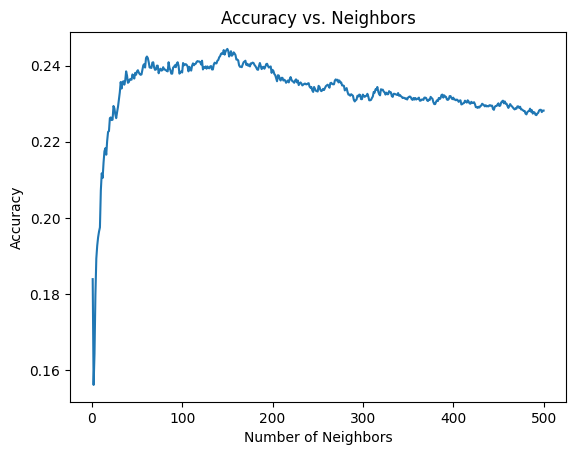

In [ ]:
y_axis = []
x_axis = [x for x in range(1, 501)]
#Attempt at graphing accuracies at different numbers of neighbors
for value in x_axis:
    knn_model = KNeighborsClassifier(n_neighbors = value)
    knn_model.fit(X_train_flattened, y_train)
    y_pred = knn_model.predict(X_test)
    y_axis.append(accuracy_score(y_test,y_pred))

plt.plot(x_axis, y_axis)
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Neighbors')
plt.show

In [ ]:
y_axis3 = []
x_axis3 = range(1, 501)
#Attempt at graphing accuracies at different numbers of neighbors
for value in x_axis3:
    knn_model = KNeighborsClassifier(n_neighbors = value)
    knn_model.fit(X_train_flattened, y_train)
    y_pred = knn_model.predict(X_test)
    y_axis3.append(accuracy_score(y_test,y_pred))

plt.plot(x_axis3, y_axis3)
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Neighbors')
plt.show

NameError: name 'KNeighborsClassifier' is not defined

<function matplotlib.pyplot.show(close=None, block=None)>

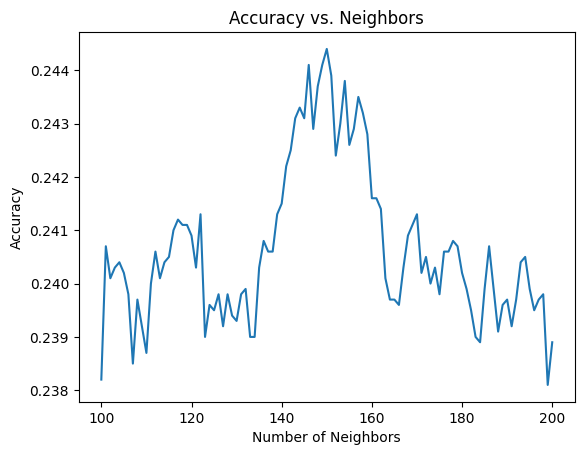

In [17]:
y_axis2 = []
x_axis2 = [x for x in range(100, 201)]
#Attempt at graphing accuracies at different numbers of neighbors
for value in x_axis2:
    knn_model = KNeighborsClassifier(n_neighbors = value)
    knn_model.fit(X_train_flattened, y_train)
    y_pred = knn_model.predict(X_test)
    y_axis2.append(accuracy_score(y_test,y_pred))

plt.plot(x_axis2, y_axis2)
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Neighbors')
plt.show

In [11]:
from sklearn import svm
from sklearn.svm import SVC


In [ ]:
model = SVC(kernel='rbf', gamma='scale')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)


In [10]:
foo = np.zeros((X_train.shape[0], 10))
foo[np.arange(X_train.shape[0]), y_train] = 1
foo.shape

(50000, 10)

In [12]:
new_y_train = np.zeros((len(y_train), 10))
for i in range(len(y_train)):
    labelList = [0,0,0,0,0,0,0,0,0,0]
    labelList[y_train[i]] += 1
    new_y_train[i] = labelList

new_y_test = np.zeros((len(y_test), 10))
for i in range(len(y_test)):
    labelList = [0,0,0,0,0,0,0,0,0,0]
    labelList[y_test[i]] += 1
    new_y_test[i] = labelList
print(new_y_test.shape)
print(new_y_train.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(10000, 10)
(50000, 10)
(50000, 3072)
(50000,)
(10000, 3072)


In [59]:
#TODO: CNN here
firstCNNModel = CNNClassifier(num_epochs=30, layers=8, dropout=0.25)
firstCNNModel.fit(X_train, new_y_train)
print(firstCNNModel.predict(X_test))
print(firstCNNModel.score(X_test, new_y_test))

Epoch 1/30
5000/5000 - 92s - 18ms/step - accuracy: 0.2100 - loss: 2.1686
Epoch 2/30
5000/5000 - 90s - 18ms/step - accuracy: 0.2613 - loss: 2.0500
Epoch 3/30
5000/5000 - 91s - 18ms/step - accuracy: 0.2838 - loss: 1.9949
Epoch 4/30
5000/5000 - 91s - 18ms/step - accuracy: 0.2953 - loss: 1.9619
Epoch 5/30
5000/5000 - 92s - 18ms/step - accuracy: 0.3031 - loss: 1.9434
Epoch 6/30
5000/5000 - 92s - 18ms/step - accuracy: 0.3085 - loss: 1.9270
Epoch 7/30
5000/5000 - 92s - 18ms/step - accuracy: 0.3169 - loss: 1.9115
Epoch 8/30
5000/5000 - 93s - 19ms/step - accuracy: 0.3204 - loss: 1.9015
Epoch 9/30
5000/5000 - 92s - 18ms/step - accuracy: 0.3207 - loss: 1.8938
Epoch 10/30
5000/5000 - 93s - 19ms/step - accuracy: 0.3240 - loss: 1.8834
Epoch 11/30
5000/5000 - 93s - 19ms/step - accuracy: 0.3269 - loss: 1.8750
Epoch 12/30
5000/5000 - 93s - 19ms/step - accuracy: 0.3296 - loss: 1.8705
Epoch 13/30
5000/5000 - 93s - 19ms/step - accuracy: 0.3324 - loss: 1.8629
Epoch 14/30
5000/5000 - 93s - 19ms/step - accur

In [13]:
smallerTestingCNNDropout = 0.25

smallerTestingCNN = Sequential()
smallerTestingCNN.add(Reshape((32, 32, 3)))

smallerTestingCNN.add(Conv2D(32, (9, 9), padding='same'))
smallerTestingCNN.add(Activation('relu'))

smallerTestingCNN.add(Conv2D(32, (7, 7), padding='same'))
smallerTestingCNN.add(Activation('relu'))

smallerTestingCNN.add(Conv2D(32, (5, 5), padding='same'))
smallerTestingCNN.add(Activation('relu'))

smallerTestingCNN.add(Conv2D(32, (5, 5), padding='same'))
smallerTestingCNN.add(Activation('relu'))

smallerTestingCNN.add(Conv2D(32, (5, 5), padding='same'))
smallerTestingCNN.add(Activation('relu'))

smallerTestingCNN.add(MaxPooling2D(pool_size=(2, 2)))
smallerTestingCNN.add(Dropout(smallerTestingCNNDropout))

smallerTestingCNN.add(Conv2D(64, (5, 5), padding='same'))
smallerTestingCNN.add(Activation('relu'))

smallerTestingCNN.add(Conv2D(64, (5, 5)))
smallerTestingCNN.add(Activation('relu'))
smallerTestingCNN.add(MaxPooling2D(pool_size=(2, 2)))
smallerTestingCNN.add(Dropout(smallerTestingCNNDropout))

smallerTestingCNN.add(Flatten())
smallerTestingCNN.add(Dense(512))
smallerTestingCNN.add(Activation('relu'))
smallerTestingCNN.add(Dropout(smallerTestingCNNDropout))
smallerTestingCNN.add(Dense(10))
smallerTestingCNN.add(Activation('softmax'))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 66ms/step - accuracy: 0.1563 - loss: 2.3709 - val_accuracy: 0.2248 - val_loss: 2.1187
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 101s 65ms/step - accuracy: 0.2267 - loss: 2.1258 - val_accuracy: 0.2389 - val_loss: 2.1193
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 65ms/step - accuracy: 0.2144 - loss: 2.1535 - val_accuracy: 0.2252 - val_loss: 2.1234
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - accuracy: 0.2249 - loss: 2.1220 - val_accuracy: 0.2331 - val_loss: 2.1049
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 101s 65ms/step - accuracy: 0.2411 - loss: 2.0947 - val_accuracy: 0.2438 - val_loss: 2.0796


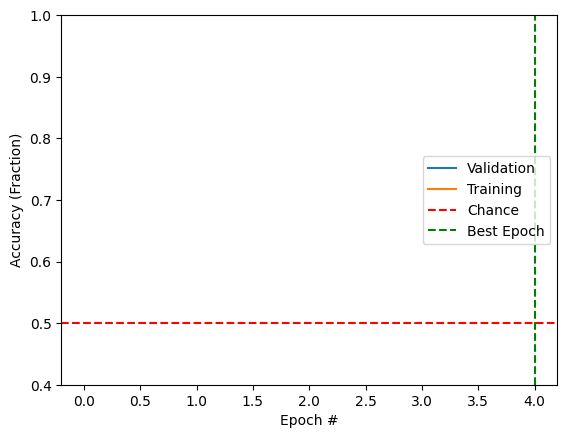

In [14]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

smallerTestingCNN.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history = smallerTestingCNN.fit(X_train, new_y_train,
                    validation_data=(X_test, new_y_test),
                    epochs=5)
plot_acc(history)

In [20]:
#Second CNN
#Built by me
#Big fat model:
bigCompExplodingCNNDropout = 0.25
layers = 25

bigCompExplodingCNN = Sequential()
bigCompExplodingCNN.add(Reshape((32, 32, 3)))

bigCompExplodingCNN.add(Conv2D(32, (7, 7), padding='same'))
bigCompExplodingCNN.add(Activation('relu'))

bigCompExplodingCNN.add(Conv2D(32, (5, 5), padding='same'))
bigCompExplodingCNN.add(Activation('relu'))

for i in range(layers):
    bigCompExplodingCNN.add(Conv2D(32, (5, 5), padding='same'))
    bigCompExplodingCNN.add(Activation('relu'))

bigCompExplodingCNN.add(Conv2D(32, (5, 5)))
bigCompExplodingCNN.add(Activation('relu'))
bigCompExplodingCNN.add(MaxPooling2D(pool_size=(2, 2)))
bigCompExplodingCNN.add(Dropout(bigCompExplodingCNNDropout))

bigCompExplodingCNN.add(Conv2D(64, (5, 5), padding='same'))
bigCompExplodingCNN.add(Activation('relu'))

bigCompExplodingCNN.add(Conv2D(64, (5, 5)))
bigCompExplodingCNN.add(Activation('relu'))
bigCompExplodingCNN.add(MaxPooling2D(pool_size=(2, 2)))
bigCompExplodingCNN.add(Dropout(bigCompExplodingCNNDropout))

bigCompExplodingCNN.add(Flatten())
bigCompExplodingCNN.add(Dense(512))
bigCompExplodingCNN.add(Activation('relu'))
bigCompExplodingCNN.add(Dropout(bigCompExplodingCNNDropout))
bigCompExplodingCNN.add(Dense(10))
bigCompExplodingCNN.add(Activation('softmax'))

Epoch 1/500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 413s 258ms/step - accuracy: 0.1433 - loss: 2.2655 - val_accuracy: 0.1902 - val_loss: 2.2147
Epoch 2/500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 368s 235ms/step - accuracy: 0.2068 - loss: 2.1514 - val_accuracy: 0.2311 - val_loss: 2.1015
Epoch 3/500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 369s 236ms/step - accuracy: 0.2301 - loss: 2.1043 - val_accuracy: 0.2539 - val_loss: 2.0585
Epoch 4/500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 356s 227ms/step - accuracy: 0.2496 - loss: 2.0660 - val_accuracy: 0.2623 - val_loss: 2.0475
Epoch 5/500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 350s 224ms/step - accuracy: 0.2633 - loss: 2.0363 - val_accuracy: 0.2701 - val_loss: 2.0199
Epoch 6/500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 350s 224ms/step - accuracy: 0.2747 - loss: 2.0132 - val_accuracy: 0.2609 - val_loss: 2.0344
Epoch 7/500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 362s 232ms/step - accuracy: 0.2855 - loss: 1.9911 - val_accuracy: 0.2677 - val_loss: 2.0227
Epoch 8/500
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 369s 236ms/s

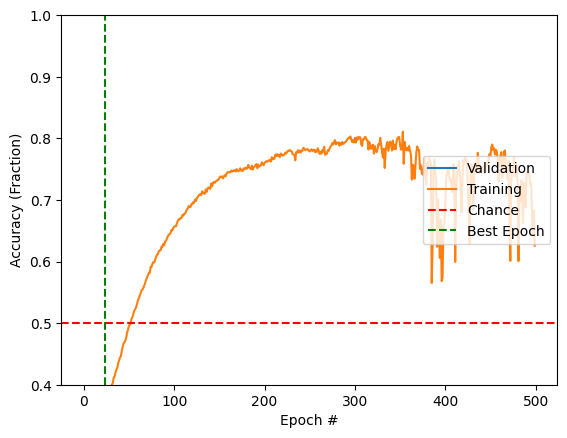

In [21]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
bigCompExplodingCNN.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the CNN and plot accuracy.
history = bigCompExplodingCNN.fit(X_train, new_y_train,
                    validation_data=(X_test, new_y_test),
                    epochs=500)
plot_acc(history)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
#y_pred_labels = np.argmax(y_pred, axis=1)
print(accuracy_score(y_test, np.argmax(bigCompExplodingCNN.predict(X_test), axis=1)))
print(precision_score(y_test, np.argmax(bigCompExplodingCNN.predict(X_test), axis=1), average='weighted'))
print(recall_score(y_test, np.argmax(bigCompExplodingCNN.predict(X_test), axis=1), average='weighted'))
print(f1_score(y_test, np.argmax(bigCompExplodingCNN.predict(X_test), axis=1), average='weighted'))
cm = confusion_matrix(y_test, np.argmax(bigCompExplodingCNN.predict(X_test), axis=1))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step
0.2472
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step
0.24535443339485183
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step
0.2472
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step
0.24534774753737543
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step


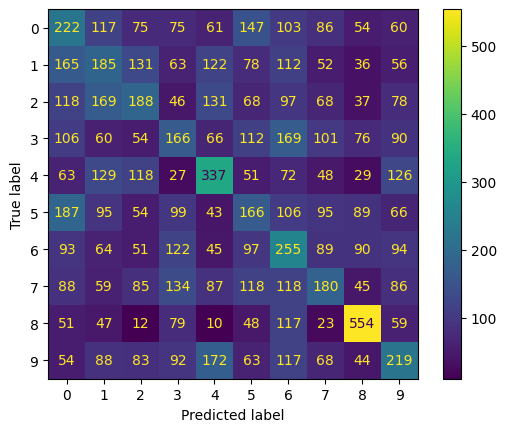

In [49]:
disp.plot()
plt.show()

In [29]:
print(bigCompExplodingCNN.predict(X_test))
#print(accuracy_score(new_y_test, fattie.predict(X_test)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step
[[4.4514112e-02 3.7912242e-02 1.1225345e-02 ... 3.6521773e-03
  5.4027909e-01 1.8222755e-02]
 [4.4848846e-04 3.9728420e-04 1.7488182e-04 ... 6.4474312e-03
  5.7837344e-05 3.9789407e-03]
 [1.7716538e-02 2.1822986e-03 3.7815508e-02 ... 7.0035839e-01
  7.2098869e-06 1.3282850e-02]
 ...
 [2.0197949e-01 1.5887941e-01 3.6469117e-02 ... 1.3961775e-03
  4.5612383e-01 9.5007481e-04]
 [1.0879048e-02 2.5495156e-03 5.8291992e-04 ... 5.7768112e-01
  8.5248921e-06 1.3009382e-04]
 [4.7575165e-02 4.0511875e-03 1.6294306e-02 ... 5.8974296e-01
  6.0707831e-04 4.1980606e-02]]


In [ ]:
fattieResults = open("fattieResults.txt", "a")
fattieResults.write("\n\nFattie Results:\n")
fattieResults.write(bigCompExplodingCNN.predict(X_test))